In [4]:
data <- read.csv("../data/恒生综合指数-能源业历史数据weekly.csv", header = TRUE, col.names = c("date", "close", "open", "high", "low", "volume", "variation"))
data$date <- as.Date(data$date)
data$close <- as.numeric(gsub(",", "", data$close))
sorted_index <- order(data$date)
data <- data[sorted_index, ]
data = with(data, data[(date >= "2020-02-02"), ])

data$logReturn = c(NA, diff(log(data$close)))

In [5]:
trainset = with(data, data[(date >= "2020-02-02") & (date <= "2024-02-29"), ])
testset = with(data, data[(date > "2024-02-29"), ])

In [6]:
trainTs = ts(na.omit(trainset$logReturn), freq=52, start=c(2020, 2))
testTs = ts(na.omit(testset$logReturn), freq=52, start=c(2024, 2))

#### line plot of close and logReturn

In [7]:
library(ggplot2)
library(gridExtra)

Warning message:
"package 'gridExtra' was built under R version 4.3.3"


Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


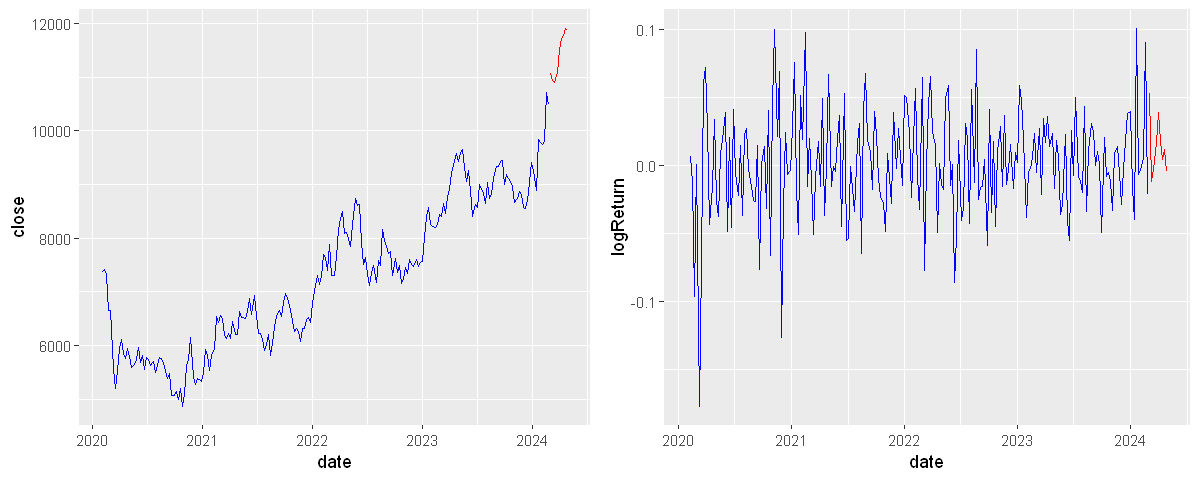

In [8]:
p1 <- ggplot()
p1 <- p1 + geom_line(data = trainset, aes(x=date, y=close), color = "blue")
p1 <- p1 + geom_line(data = testset, aes(x = date, y=close), color = "red")

p2 <- ggplot()
p2 <- p2 + geom_line(data = trainset, aes(x=date, y=logReturn), color = "blue")
p2 <- p2 + geom_line(data = testset, aes(x = date, y=logReturn), color = "red")

options(repr.plot.width = 10, repr.plot.height = 4)

grid.arrange(p1, p2, ncol = 2, widths = c(0.4, 0.4), heights = c(0.6))

#### draw the ACF and PACF

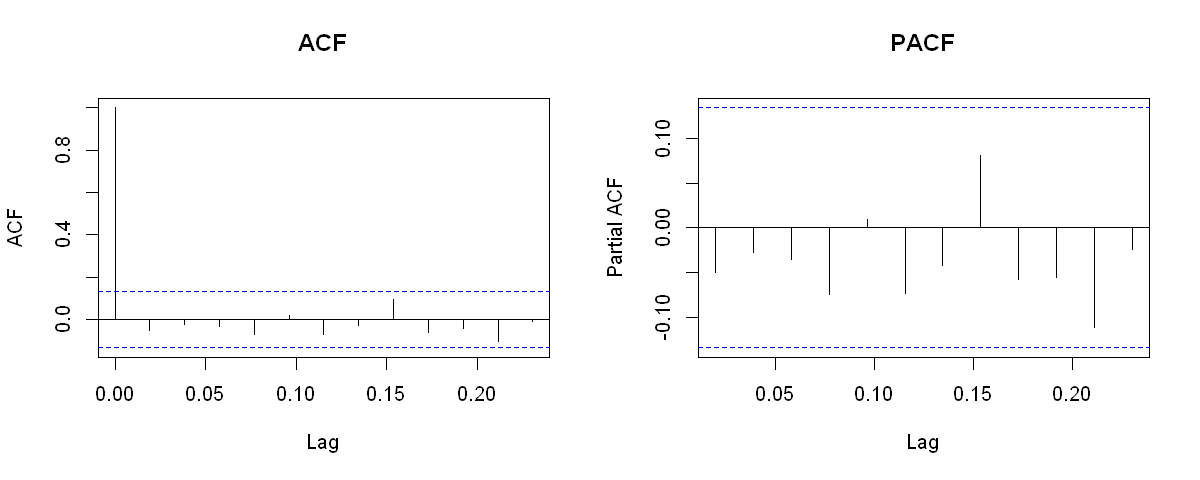

In [9]:
par(mfrow = c(1, 2))
plot_acf <- acf(trainTs, lag.max = 12, main = "ACF")
plot_pacf <- pacf(trainTs, lag.max = 12, main = "PACF")
par(mfrow = c(1, 1)) # return to the default

#### 2.1 ARIMA

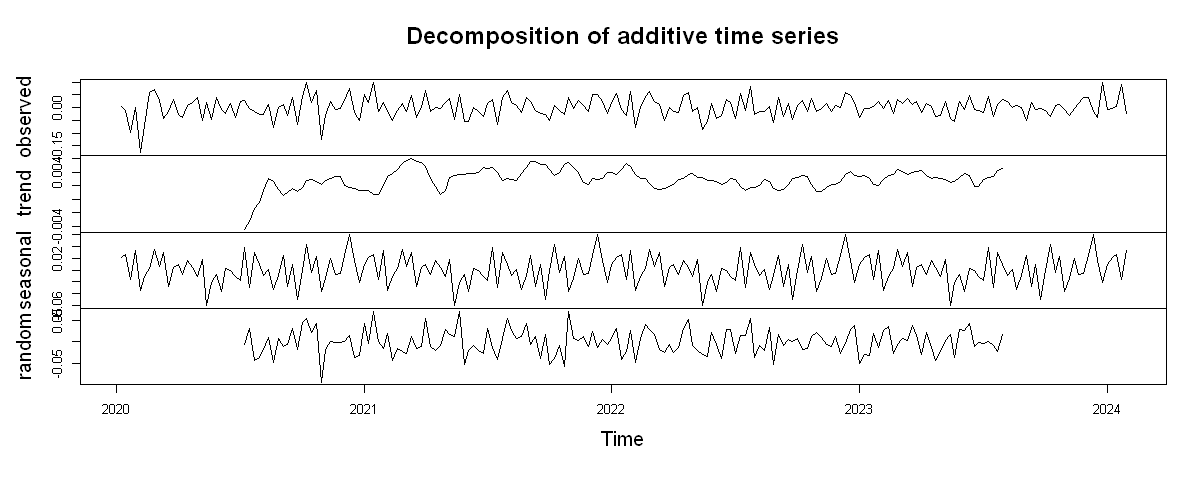

In [10]:
mcomponents <- decompose(trainTs)
plot(mcomponents)

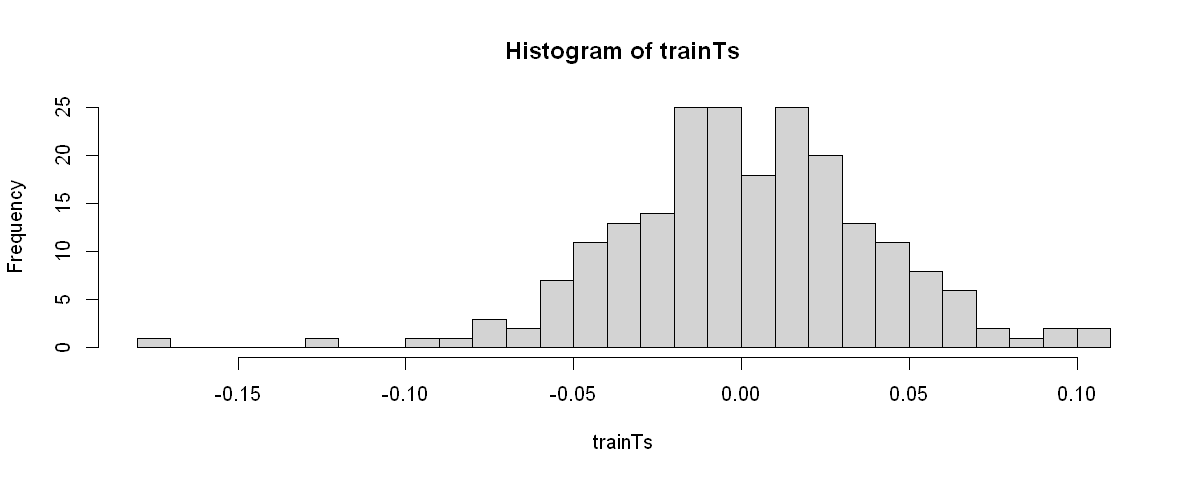

In [11]:
hist(trainTs,breaks = 20)

In [12]:
mean(((trainTs-mean(trainTs))/sd(trainTs))^3)
mean(((trainTs-mean(trainTs))/sd(trainTs))^4)

[1] -0.4149926

[1] 4.71774

In [13]:
epsilon_t=trainTs-mean(trainTs)
 x<-na.omit(epsilon_t)
 x<-x+0.0000000000000001*rnorm(length(x),0,1)
ks.test(x,"pnorm",mean=mean(x),sd=sd(x))


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  x
D = 0.050505, p-value = 0.6518
alternative hypothesis: two-sided


In [14]:
library("Rfast")
library("ramify")
library("LambertW")

x<-na.omit(trainTs) #Store the target data 
x<-na.omit(x)           #remove "NA" in the dataset
x<-as.matrix(x)         #ensure that the data is in matrix form
df=seq(1,100,0.001)       #set the range of degree of freedom (e.g. df=[2,2.001,...,8])
n=length(df)            
loglik=rep(0,n)         #Used to store the value of loglikelihood function for different level of df
for(i in 1:n){
  fitres=mvt.mle(x,v=df[i])
  loglik[i]=fitres$loglik
}                   #For each df, calculate the MLE and loglikelihood function
loglik<-as.matrix(loglik)
dfmax=df[argmax(loglik,rows=FALSE)] #Find the maximizier(optimal df)
fitMLE=mvt.mle(x,v=dfmax) #Estimate the MLE of the parameters

m<-fitMLE$location            #m=mu (location)
s<-sqrt(fitMLE$scatter[1,1])  #s=lambda (scale parameter)
print(m)
print(s)
print(dfmax)

ks_test_t(x,c(location=m,scale=s,df=dfmax)) #do the testing using ks.test

Loading required package: Rcpp

Loading required package: RcppZiggurat


Rfast:  2.0.8

 ___ __ __ __ __    __ __ __ __ __ _             _               __ __ __ __ __     __ __ __ __ __ __   
|  __ __ __ __  |  |  __ __ __ __ _/            / \             |  __ __ __ __ /   /__ __ _   _ __ __\  
| |           | |  | |                         / _ \            | |                        / /          
| |           | |  | |                        / / \ \           | |                       / /          
| |           | |  | |                       / /   \ \          | |                      / /          
| |__ __ __ __| |  | |__ __ __ __           / /     \ \         | |__ __ __ __ _        / /__/\          
|    __ __ __ __|  |  __ __ __ __|         / /__ _ __\ \        |_ __ __ __ _   |      / ___  /           
|   \              | |                    / _ _ _ _ _ _ \                     | |      \/  / /       
| |\ \             | |                   / /           \ \                 

[1] 0.002204152
[1] 0.03380909
[1] 7.884



	One-sample Kolmogorov-Smirnov test student-t with df=7.88, location=0,
	scale=0.03

data:  x
D = 0.035359, p-value = 0.9537
alternative hypothesis: two-sided


In [15]:
# library(fGarch)

# sgedFit(x)

In [16]:
library(nortest)
x<-na.omit(trainTs)
ad.test(x)


	Anderson-Darling normality test

data:  x
A = 0.45708, p-value = 0.263


In [17]:
library(goftest)
x<-na.omit(trainTs)
x2=(x-m)/s
ad.test(x2,null = "pt",df=dfmax)


Attaching package: 'goftest'


The following objects are masked from 'package:nortest':

    ad.test, cvm.test





	Anderson-Darling test of goodness-of-fit
	Null hypothesis: Student's t distribution
	with parameter df = 7.884
	Parameters assumed to be fixed

data:  x2
An = 0.18311, p-value = 0.9943


In [18]:
w1=diff(trainTs,52)

In [19]:
library(fUnitRoots)
adfTest(w1)

Warning message:
"package 'fUnitRoots' was built under R version 4.3.3"
Warning message in adfTest(w1):
"p-value smaller than printed p-value"



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -9.7402
  P VALUE:
    0.01 

Description:
 Sun May  5 14:32:52 2024 by user: 82438

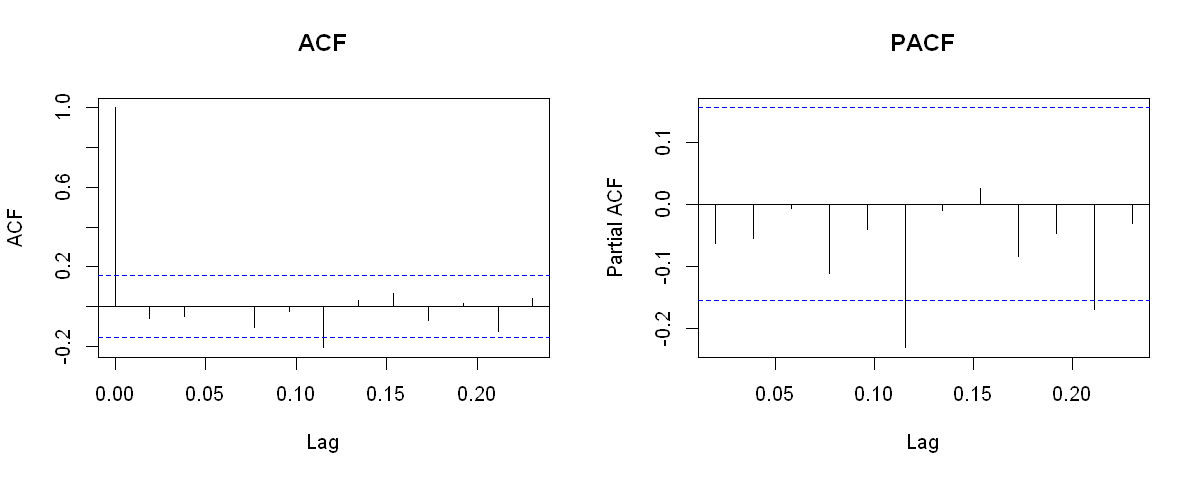

In [20]:
par(mfrow = c(1, 2))
plot_acf <- acf(w1, lag.max = 12, main = "ACF")
plot_pacf <- pacf(w1, lag.max = 12, main = "PACF")
par(mfrow = c(1, 1)) # return to the default

In [21]:
library(forecast)
auto.arima(w1)

Warning message:
"package 'forecast' was built under R version 4.3.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Series: w1 
ARIMA(0,0,0)(1,0,0)[52] with non-zero mean 

Coefficients:
         sar1    mean
      -0.5644  0.0019
s.e.   0.0721  0.0025

sigma^2 = 0.00193:  log likelihood = 264.04
AIC=-522.07   AICc=-521.92   BIC=-512.85

In [22]:
model_arma1=arima(w1, order = c(0,0,0),seasonal = list(order = c(1,0,0),  period = 52),include.mean = F)
model_arma1


Call:
arima(x = w1, order = c(0, 0, 0), seasonal = list(order = c(1, 0, 0), period = 52), 
    include.mean = F)

Coefficients:
         sar1
      -0.5643
s.e.   0.0722

sigma^2 estimated as 0.001912:  log likelihood = 263.75,  aic = -523.5

In [23]:
model_arma2=arima(w1, order = c(0,0,0),seasonal = list(order = c(0,0, 1),  period = 52),include.mean = F)
model_arma2


Call:
arima(x = w1, order = c(0, 0, 0), seasonal = list(order = c(0, 0, 1), period = 52), 
    include.mean = F)

Coefficients:
         sma1
      -0.6045
s.e.   0.1417

sigma^2 estimated as 0.00195:  log likelihood = 260.8,  aic = -517.59

In [24]:
model_arma3=arima(w1, order = c(1,0,1),seasonal = list(order = c(0,0, 1),  period = 52),include.mean = F)
model_arma3


Call:
arima(x = w1, order = c(1, 0, 1), seasonal = list(order = c(0, 0, 1), period = 52), 
    include.mean = F)

Coefficients:
        ar1      ma1     sma1
      0.794  -0.9225  -0.5850
s.e.  0.094   0.0665   0.1368

sigma^2 estimated as 0.001904:  log likelihood = 263.39,  aic = -518.77

In [25]:
model_arma4=arima(w1, order = c(1,0,1),seasonal = list(order = c(1,0, 0),  period = 52),include.mean = F
#                   ,fixed = c(NA,0,NA,NA,NA,NA,NA)
                  )
model_arma4


Call:
arima(x = w1, order = c(1, 0, 1), seasonal = list(order = c(1, 0, 0), period = 52), 
    include.mean = F)

Coefficients:
         ar1      ma1     sar1
      0.8049  -0.9323  -0.5569
s.e.  0.0891   0.0624   0.0736

sigma^2 estimated as 0.001856:  log likelihood = 266.29,  aic = -524.58

In [26]:
Box.test(model_arma4$residuals,lag = 12,type = "Ljung")


	Box-Ljung test

data:  model_arma4$residuals
X-squared = 4.499, df = 12, p-value = 0.9727


In [27]:
pv1=1-pchisq(4.499,9)
pv1

[1] 0.8756164

In [28]:
w1_2=w1-mean(w1)
Box.test(w1_2^2,lag = 12,type = "Ljung")


	Box-Ljung test

data:  w1_2^2
X-squared = 7.7904, df = 12, p-value = 0.8013


In [29]:
Box.test(model_arma4$residuals^2,lag = 12,type = "Ljung")


	Box-Ljung test

data:  model_arma4$residuals^2
X-squared = 8.2134, df = 12, p-value = 0.7682


In [30]:
# library(rugarch)

In [31]:
# spec_s <- ugarchspec(
#   variance.model = list(
#     garchOrder = c(1, 1), #I've tried a few, starting at (1,1). those yielded the "best" model
#     model = "sGARCH",
#     submodel = NULL,
#     external.regressors = NULL,
#     variance.targeting = F),
#   mean.model = list(
#     armaOrder = c(0, 0), #the parameters previously identified using auto.arima()
#     external.regressors = fourier(w1, K = 26, h = NULL)), #seasonality in the differenced ts
#     distribution.model = "std"
#   ,fixed.par=list(omega=0)
# )

# garch_s <- ugarchfit(
#   spec = spec_s,
#   data = w1,
#   solver = "hybrid"
# )


In [32]:
# res_s=residuals(garch_s,standardize=T)
# Box.test(res_s,10,type="Ljung")
# Box.test(res_s^2,10,type="Ljung")

In [33]:
# pv1=1-pchisq(7.5235,8)
# pv1
# pv2=1-pchisq(20.467,8)
# pv2

In [34]:
# spec_i <- ugarchspec(
#   variance.model = list(
#     garchOrder = c(1, 1), #I've tried a few, starting at (1,1). those yielded the "best" model
#     model = "iGARCH",
#     submodel = NULL,
#     external.regressors = NULL,
#     variance.targeting = F),
#   mean.model = list(
#     armaOrder = c(0, 0), #the parameters previously identified using auto.arima()
#     external.regressors = fourier(week_logreturn, K = 26, h = NULL)), #seasonality in the differenced ts
#     distribution.model = "std"
#   ,fixed.par=list(omega=0)
# )

# garch_i <- ugarchfit(
#   spec = spec_i,
#   data = week_logreturn,
#   solver = "hybrid"
# )

In [35]:
forecast=predict(model_arma4, n.ahead=9)
# forecasts <- ugarchforecast(garch_s, n.ahead = 9)
# forecasts

In [36]:
#Step 9:Forecasting
forecast=predict(model_arma4, n.ahead=9)
forecast$pred
# forecast$se

U=forecast$pred +1.96 * forecast$se
L=forecast$pred - 1.96 * forecast$se

U
L

A Time Series:
[1] -0.041221041 -0.015727141  0.036522571  0.016665387  0.003840303
[6] -0.012493765 -0.035479885 -0.012638077  0.001550903

A Time Series:
[1] 0.04322064 0.06939726 0.12208631 0.10251253 0.08987053 0.07365486 0.05074534
[8] 0.07363674 0.08785782

A Time Series:
[1] -0.12566272 -0.10085154 -0.04904117 -0.06918176 -0.08218992 -0.09864238
[7] -0.12170511 -0.09891289 -0.08475602

In [37]:
# forecasts

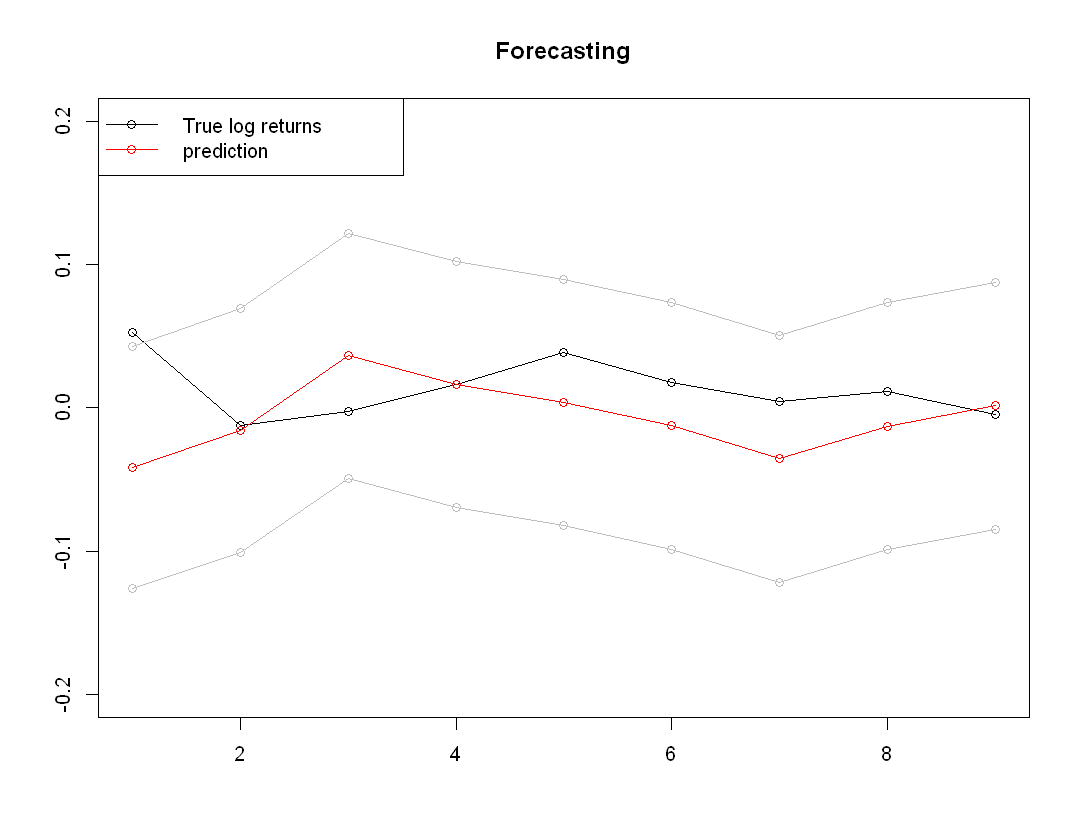

In [38]:
options(repr.plot.width = 9, repr.plot.height = 7)

plot(1:9, testTs,ylim=c(-0.2, 0.2),type="o", ylab="",xlab="",main="Forecasting")
lines(1:9,testTs,type="o",col="black")
lines(1:9,forecast$pred,type="o",col="red")
lines(1:9,U,type="o",col="grey")
lines(1:9,L,type="o",col="grey")

legend(x="topleft",c("True log returns","prediction"),lty=c(1,1),pch=c(1,1),col=c("black","red"))

In [43]:
forecast=predict(model_arma4, n.ahead=1)
forecast$pred[1]

[1] -0.04122104

In [45]:
# rolling forecast
testshape = length(testTs)
data_t = trainTs
predMean = rep(0, testshape)
predSig = rep(0, testshape)

for (i in 1:testshape){
    w1=diff(data_t, 52)
    model=arima(w1, order = c(1,0,1),seasonal = list(order = c(1,0, 0),  period = 52),include.mean = F
    #                   ,fixed = c(NA,0,NA,NA,NA,NA,NA)
                      )
    forecast=predict(model, n.ahead=1)
    predMean[i] = forecast$pred[1]
    predSig[i] = forecast$se[1]
    data_t = c(trainTs, testTs[i])
}

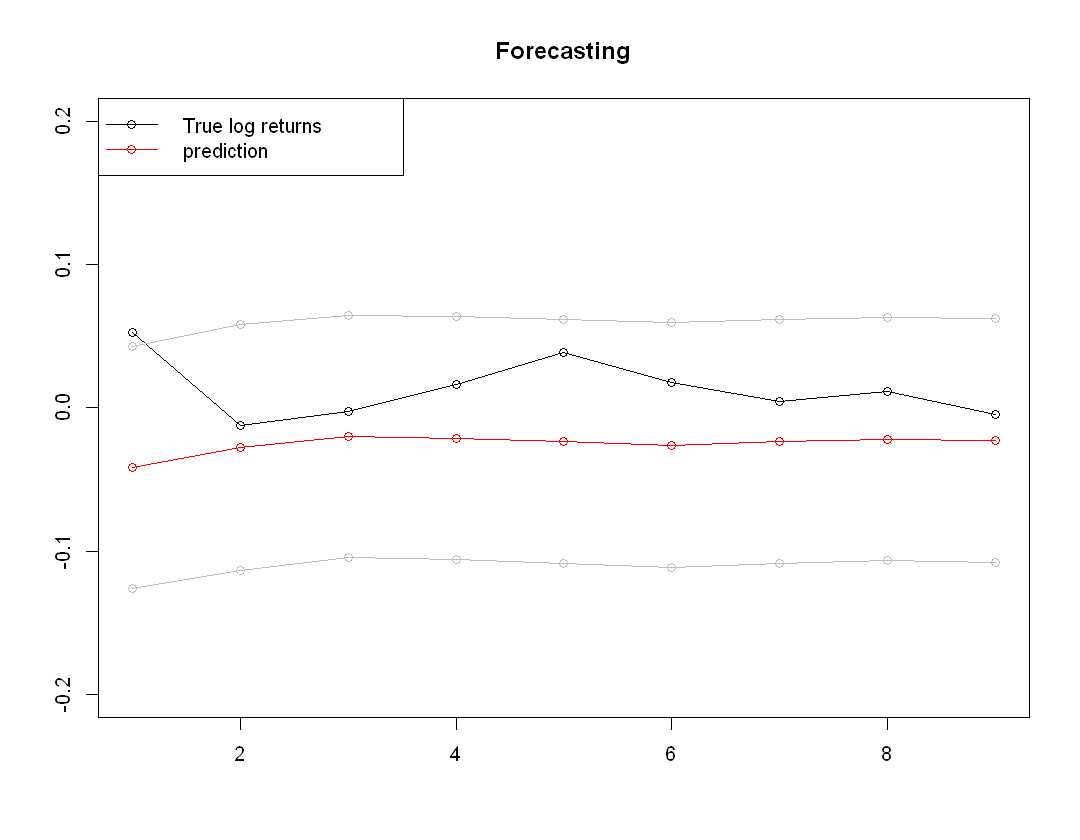

In [48]:

options(repr.plot.width = 9, repr.plot.height = 7)

plot(1:9, testTs,ylim=c(-0.2, 0.2),type="o", ylab="",xlab="",main="Forecasting")
lines(1:9,testTs,type="o",col="black")
lines(1:9,predMean,type="o",col="red")
lines(1:9,predMean +1.96 * predSig,type="o",col="grey")
lines(1:9,predMean -1.96 * predSig,type="o",col="grey")

legend(x="topleft",c("True log returns","prediction"),lty=c(1,1),pch=c(1,1),col=c("black","red"))

In [39]:
residuals_fina=residuals(model_arma4,standardize=T)
# residuals_fina=residuals(garch_s,standardize=T)

In [179]:
write.table(residuals_fina, "../data/residuals_energy.txt", sep = "\t", quote = FALSE, row.names = FALSE)

In [40]:
coef(model_arma4)

ar1        ma1       sar1 
 0.8048514 -0.9322697 -0.5569412